In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import argparse
import os
import torch  # put this before scipy import

import sys
sys.path.append(os.path.join(sys.path[0],'..','tools'))

from mattnet import MattNet

%pylab inline
import matplotlib.pyplot as plt

from itertools import product
import numpy as np
from scipy.misc import imread, imresize
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


In [2]:
# box functions
def xywh_to_xyxy(boxes):
    """Convert [x y w h] box format to [x1 y1 x2 y2] format."""
    return np.hstack((boxes[:, 0:2], boxes[:, 0:2] + boxes[:, 2:4] - 1))

def show_attn(img_path, box, attn):
    """
    box : [xywh]
    attn: 49
    """
    img = imread(img_path)
    attn = np.array(attn).reshape(7,7)
    x,y,w,h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    roi = img[y:y+h-1, x:x+w-1]
    attn = imresize(attn, [h,w])
    plt.imshow(roi)
    plt.imshow(attn, alpha=0.7)
    
def show_boxes(img_path, boxes, colors, texts=None, masks=None):
    # boxes [[xyxy]]
    img = imread(img_path)
    plt.imshow(img)
    ax = plt.gca()
    for k in range(boxes.shape[0]):
        box = boxes[k]
        xmin, ymin, xmax, ymax = list(box)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[k]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        if texts is not None:
            ax.text(xmin, ymin, texts[k], bbox={'facecolor':color, 'alpha':0.5})
    # show mask
    if masks is not None:
        for k in range(len(masks)):
            mask = masks[k]
            m = np.zeros( (mask.shape[0], mask.shape[1], 3))
            m[:,:,0] = 0; m[:,:,1] = 0; m[:,:,2] = 1.
            ax.imshow(np.dstack([m*255, mask*255*0.4]).astype(np.uint8)) 
        
def save_pred(pred_path, prediction):
    a = Image.fromarray(prediction.astype(np.uint8), mode="P")
    a.putpalette(PALETTE)
    a.save(os.path.join(pred_path, str(0).zfill(5) + '.png'))

def get_prediction(masks):
    h, w = masks[0].shape
    prediction = np.zeros((h, w))
    k = 1

    for mask in masks:
        # change ones for actual k value
        prediction[np.array(mask) == 1] = k
        k += 1 
    return prediction
    
def read_annotations(annotation_file):
    # Open the file with read only permit
    f = open(annotation_file) 
    dict = {}
    for line in f:
        parts = line.split(' ')
        key = parts[0]
        if key not in dict:
            dict[key] = [None]
        else:
            dict[key].append(None)
        
    f = open(annotation_file) 
    for line in f:
        parts = line.split(' ')
        key = parts[0]
        dict[key][int(parts[1])-1] = ' '.join(parts[2:]).replace('"', '').strip()
    f.close()
    return dict

In [21]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='refcocog', help='dataset name: refclef, refcoco, refcoco+, refcocog')
parser.add_argument('--splitBy', type=str, default='umd', help='splitBy: unc, google, berkeley')
parser.add_argument('--model_id', type=str, default='mrcn_cmr_with_st', help='model id name')
args = parser.parse_args('')

In [22]:
# MattNet
mattnet = MattNet(args)

MatNet [refcocog_umd's mrcn_cmr_with_st] loaded in 1.75 seconds.
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'DATA_DIR': '/imatge/alba.herrera/maskMattnet/MAttNet/pyutils/mask-faster-rcnn/data',
 'EXP_DIR': 'res101',
 'MASK_SIZE': 14,
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_ALIGN': False,
 'POOLING_MODE': 'crop',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/imatge/alba.herrera/maskMattnet/MAttNet/pyutils/mask-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
         

In [23]:
# DAVIS query information
davis = ['17']
annot = ['annot1'] #, 'annot2']

# image path
IMAGE_DIR = '../../datasets/'
PRED_DIR = 'data/'

# expression annotations
ANNOT_DIR = '../../datasets/davis_text_annotations/'
expr = ''

# save masks palette
PALETTE = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128, 64,
           0, 0, 191, 0, 0, 64, 128, 0, 191, 128, 0, 64, 0, 128]


a handicapped girl wearing green


/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


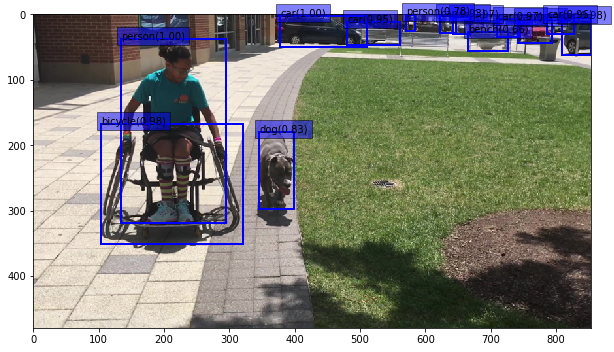

sub(0.80): (a,0.03)(handicapped,0.12)(girl,0.39)(wearing,0.11)(green,0.34)
loc(0.13): (a,0.07)(handicapped,0.26)(girl,0.34)(wearing,0.11)(green,0.22)
rel(0.06): (a,0.05)(handicapped,0.05)(girl,0.54)(wearing,0.16)(green,0.20)
[(u'woman', 0.30509257316589355), (u'boy', 0.2668456435203552), (u'young', 0.17355678975582123), (u'girl', 0.1401321440935135), (u'child', 0.11055413633584976)]


/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/imatge/alba.herrera/maskMattnet/MAttNet/venv2/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app


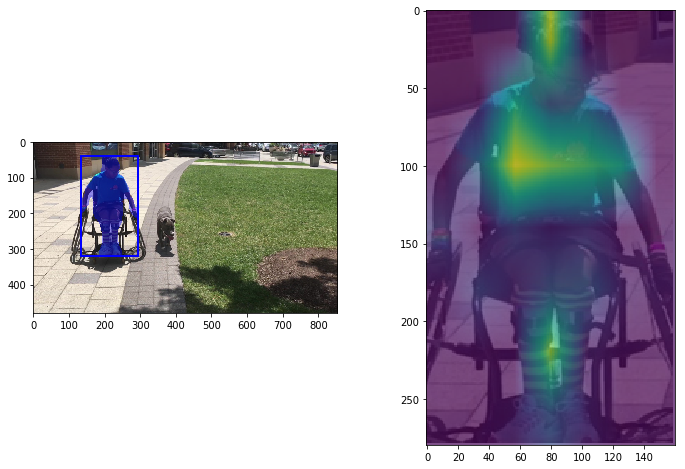

a black dog


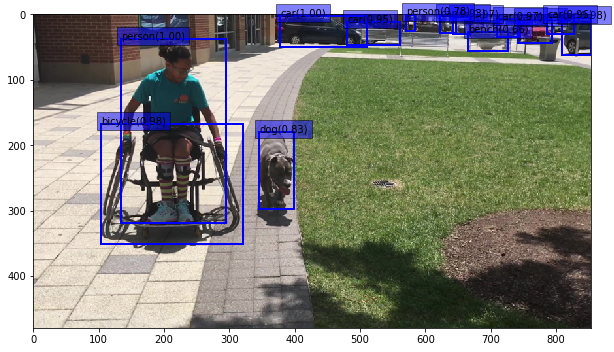

sub(0.86): (a,0.05)(black,0.53)(dog,0.42)
loc(0.13): (a,0.13)(black,0.55)(dog,0.32)
rel(0.01): (a,0.17)(black,0.35)(dog,0.48)
[(u'woman', 0.30509257316589355), (u'boy', 0.2668456435203552), (u'young', 0.17355678975582123), (u'girl', 0.1401321440935135), (u'child', 0.11055413633584976)]


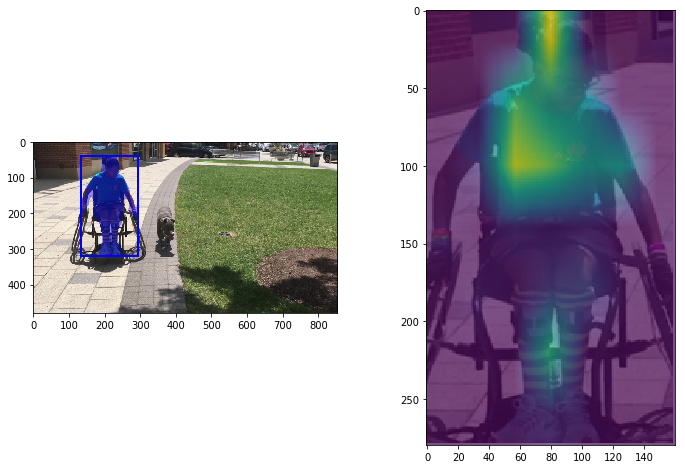

a wheelchair


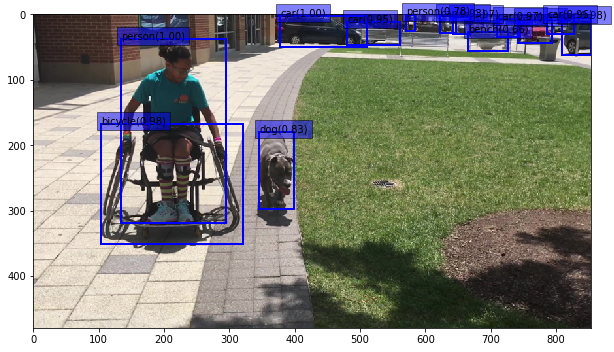

sub(0.77): (a,0.08)(wheelchair,0.92)
loc(0.19): (a,0.13)(wheelchair,0.87)
rel(0.04): (a,0.19)(wheelchair,0.81)
[(u'black', 0.20505794882774353), (u'bike', 0.16664092242717743), (u'white', 0.06347374618053436), (u'woman', 0.050778828561306), (u'blue', 0.04462074488401413)]


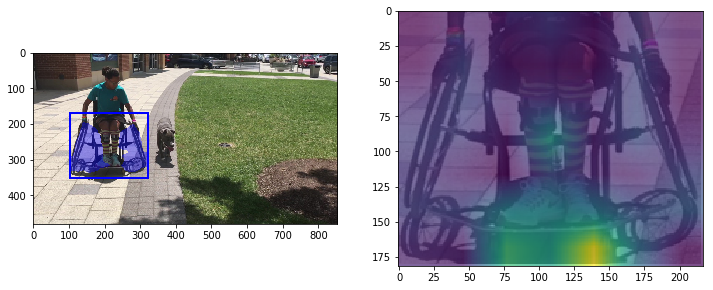

In [24]:
for d, a in product(davis, annot):
    
    annotation_file = 'Davis' + d + '_' + a + '.txt'
    dict = read_annotations(ANNOT_DIR + annotation_file)
    key = "girl-dog"

    img_path = os.path.join(IMAGE_DIR, 'DAVIS' + d,'JPEGImages/480p/', key, str(0).zfill(5) + '.jpg')
    pred_path = os.path.join(PRED_DIR, 'DAVIS' + d + '_480p_masks', a, key)
    # forward image
    img_data = mattnet.forward_image(img_path, nms_thresh=0.3, conf_thresh=0.50)
    masks = []
    for expr in dict[key]:
        print(expr)
        # comprehend expression
        entry = mattnet.comprehend(img_data, expr)
        # show masks
        plt.rcParams['figure.figsize'] = (10., 8.)
        dets = img_data['dets']
        show_boxes(img_path, xywh_to_xyxy(np.array([det['box'] for det in dets])), 
                   ['blue']*len(dets), ['%s(%.2f)' % (det['category_name'], det['score']) for det in dets])
        plt.show()
        plt.close()
        # visualize
        tokens = expr.split()
        print('sub(%.2f):' % entry['weights'][0], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['sub_attn'])]))
        print('loc(%.2f):' % entry['weights'][1], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['loc_attn'])]))
        print('rel(%.2f):' % entry['weights'][2], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['rel_attn'])]))
        # predict attribute on the predicted object
        print(entry['pred_atts'])
        # show prediction
        plt.rcParams['figure.figsize'] = (12., 8.)
        fig = plt.figure()
        plt.subplot(121)
        show_boxes(img_path, xywh_to_xyxy(np.vstack([entry['pred_box']])), ['blue'], texts=None, masks=[entry['pred_mask']])
        plt.subplot(122)
        show_attn(img_path, entry['pred_box'], entry['sub_grid_attn'])
        plt.show()
        plt.close()
        masks.append(entry['pred_mask'])
    # pred = get_prediction(masks)
    # save_pred(pred_path, pred)